In [143]:
base_path = 'IR-Newspapers-files\\IR-files'

labels_list = {'A-J' : 0, 'BBC' : 1, 'J-P' : 2, 'NY-T' : 3}

In [146]:
from scipy.sparse.csgraph import minimum_spanning_tree
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity, pairwise_distances

import matplotlib.pyplot as plt
from scipy.optimize import linear_sum_assignment
from sklearn.preprocessing import normalize

def cluster_and_evaluate(df, true_labels_column, method='kmeans'):
    """
    Perform clustering using K-means, DBSCAN, or Gaussian Mixture Models (GMM) with cosine similarity,
    evaluate metrics, and visualize using UMAP or t-SNE.

    Parameters:
    - df: pandas DataFrame containing the data for clustering (features only).
    - true_labels_column: Column name of the true labels in the DataFrame.
    - method: Clustering method ('kmeans', 'dbscan', or 'gmm').

    Returns:
    - None (prints metrics and shows visualization).
    """
    # Separate features and true labels
    X = df.drop(columns=[true_labels_column])
    true_labels = df[true_labels_column]

    # Normalize the data for cosine similarity
    X_normalized = normalize(X)

    if method == 'kmeans':
        # Perform K-means clustering with cosine similarity
        kmeans = KMeans(n_clusters=4, random_state=42)
        similarity_matrix = cosine_similarity(X_normalized)
        predicted_labels = kmeans.fit_predict(similarity_matrix)
    elif method == 'dbscan':

        X_normalized = StandardScaler().fit_transform(X_normalized)

        # Perform DBSCAN clustering with cosine distance
        distance_matrix = pairwise_distances(X_normalized)

        mst = minimum_spanning_tree(distance_matrix).toarray()
        eps = np.max(mst[mst > 0])

        average_samples_per_cluster = X.shape[0] / 4
        min_samples = int(0.5 * average_samples_per_cluster)


        dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='cosine')
        predicted_labels = dbscan.fit_predict(distance_matrix)
        # Adjust labels for DBSCAN where -1 indicates noise
        unique_labels = np.unique(predicted_labels)
        label_mapping = {label: idx for idx, label in enumerate(unique_labels)}
        predicted_labels = np.array([label_mapping[label] for label in predicted_labels])
    elif method == 'gmm':
        # Perform Gaussian Mixture Model clustering with cosine distance
        distance_matrix = pairwise_distances(X_normalized, metric='cosine')
        gmm = GaussianMixture(n_components=4, random_state=42)
        predicted_labels = gmm.fit_predict(distance_matrix)
    else:
        raise ValueError("Invalid method. Choose 'kmeans', 'dbscan', or 'gmm'.")

    # Map predicted labels to match true labels for evaluation
    num_clusters = len(np.unique(predicted_labels))
    cost_matrix = np.zeros((num_clusters, 4))
    for i in range(num_clusters):
        for j in range(4):
            cost_matrix[i, j] = np.sum((predicted_labels == i) & (true_labels == j))

    row_ind, col_ind = linear_sum_assignment(cost_matrix, maximize=True)
    mapping = dict(zip(row_ind, col_ind))

    remapped_labels = np.array([mapping[label] if label in mapping else -1 for label in predicted_labels])

    # Calculate metrics (handle noise labels in DBSCAN)
    if len(remapped_labels) > 0 and len(true_labels) > 0:
        precision = precision_score(true_labels, remapped_labels, average='weighted', zero_division=0)
        recall = recall_score(true_labels, remapped_labels, average='weighted', zero_division=0)
        f1 = f1_score(true_labels, remapped_labels, average='weighted', zero_division=0)
        accuracy = accuracy_score(true_labels, remapped_labels)
    else:
        precision = recall = f1 = accuracy = 0.0

    # Print metrics
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    print("Accuracy:", accuracy)

    # Visualize using UMAP or t-SNE
    reducer = TSNE(n_components=2, random_state=42)
    reduced_data = reducer.fit_transform(X)

    # Define distinguishable colors for visualization
    distinct_colors = ['#e41a1c', '#377eb8', '#4daf4a', '#ff7f00'] * (num_clusters // 4 + 1)
    labels_colors = [distinct_colors[label % len(distinct_colors)] if label != -1 else '#000000' for label in predicted_labels]

    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=labels_colors, s=10)
    plt.title(f"Clustering Visualization ({method.upper()})")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")

    # Add legend with color labels
    legend_labels = labels_list.keys()
    handles = [plt.Line2D([0], [0], marker='o', color=distinct_colors[i % len(distinct_colors)], linestyle='', markersize=8, label=label)
               for i, label in enumerate(legend_labels)]
    plt.legend(handles=handles, title="Clusters")
    plt.show()

In [147]:
from sklearn.preprocessing import StandardScaler

import os
def apply_to_all_matrices(func, method):
    for dir in os.listdir(base_path):
        if dir == 'TF-IDF':
            clean_matrices = []
            lemma_matrices = []
            for file in sorted(os.listdir(f'{base_path}\\{dir}')):
                if 'clean' in file:
                    clean_matrices.append(pd.read_excel(f'{base_path}\\{dir}\\{file}').drop(columns=['DocumentIndex']))
                elif 'lemma' in file:
                    lemma_matrices.append(pd.read_excel(f'{base_path}\\{dir}\\{file}').drop(columns=['DocumentIndex']))

            clean_dfs_with_index = [df.assign(Sheet_labels=i) for i, df in enumerate(clean_matrices)]
            lemma_dfs_with_index = [df.assign(Sheet_labels=i) for i, df in enumerate(lemma_matrices)]

            clean_df = pd.concat(clean_dfs_with_index, ignore_index=True)
            lemma_df = pd.concat(lemma_dfs_with_index, ignore_index=True)

            print(f'{"-"*20}TF-IDF clean{"-"*20}')
            func(clean_df, 'Sheet_labels', method)
            print(f'{"-"*20}TF-IDF lemma{"-"*20}')
            func(lemma_df, 'Sheet_labels', method)

        else:
            for matrix in os.listdir(f'{base_path}\\{dir}'):
                df = pd.read_csv(f'{base_path}\\{dir}\\{matrix}')
                df.drop('RowIndex', axis=1, inplace=True)
                df['Sheet'] = df['Sheet'].map(labels_list)

                print(f'{"-"*20}{matrix}{"-"*20}')
                func(df, 'Sheet', method)

--------------------bert_withIDF.csv--------------------
Precision: 0.06519249903156342
Recall: 0.2553282182438193
F1 Score: 0.10386526501055873
Accuracy: 0.2553282182438193


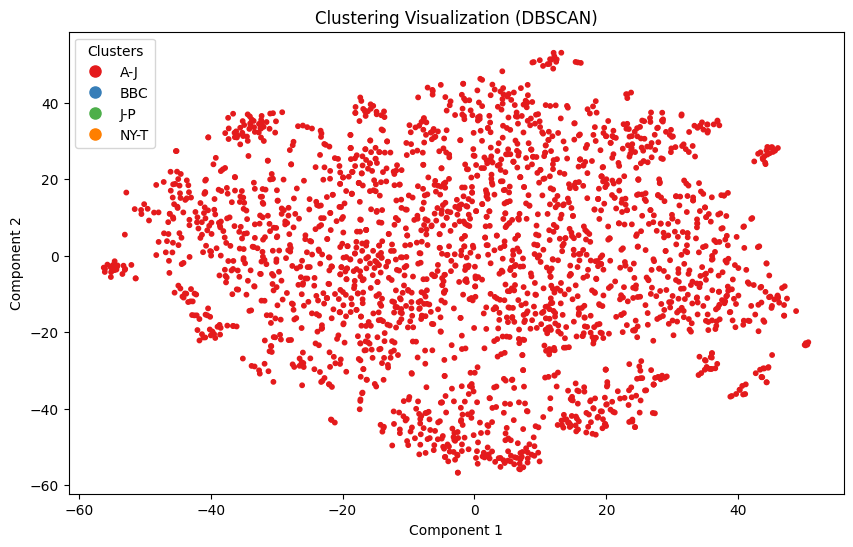

--------------------bert_withoutIDF.csv--------------------
Precision: 0.06519249903156342
Recall: 0.2553282182438193
F1 Score: 0.10386526501055873
Accuracy: 0.2553282182438193


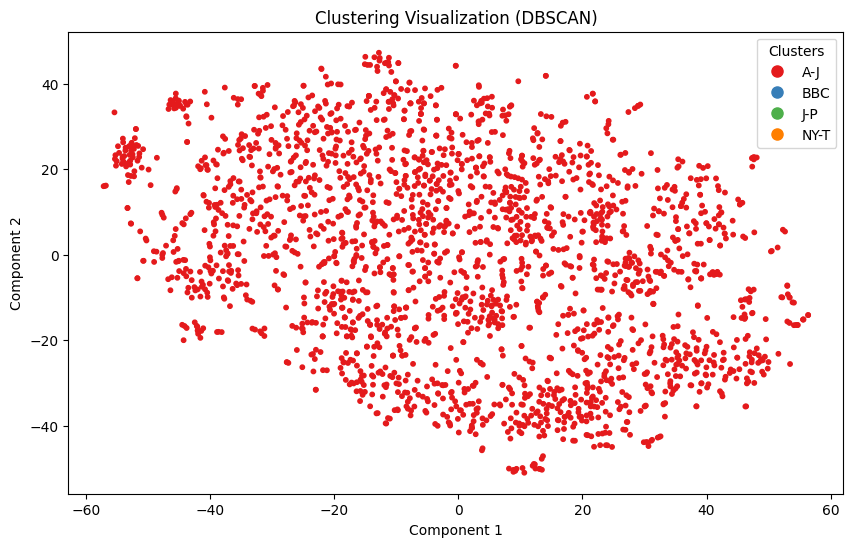

--------------------sbert_vectors.csv--------------------
Precision: 0.06519249903156342
Recall: 0.2553282182438193
F1 Score: 0.10386526501055873
Accuracy: 0.2553282182438193


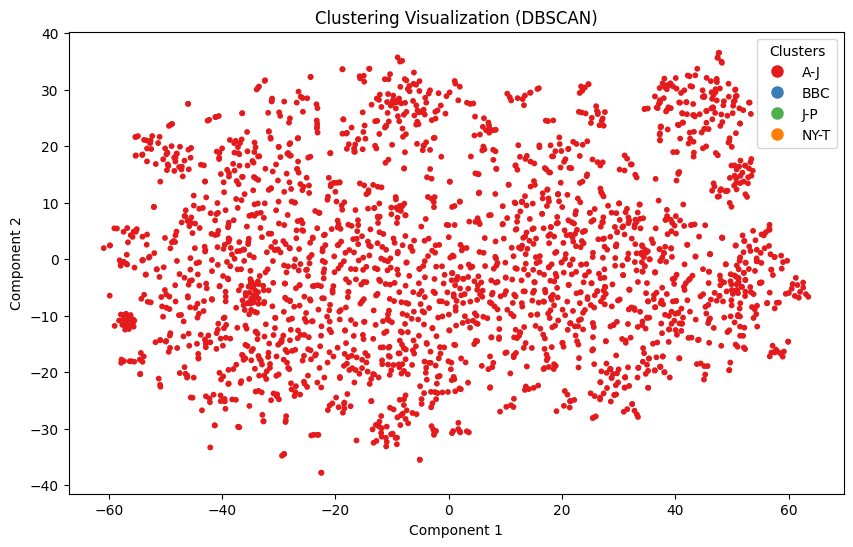

--------------------doc2vec_vectors.csv--------------------
Precision: 0.06519249903156342
Recall: 0.2553282182438193
F1 Score: 0.10386526501055873
Accuracy: 0.2553282182438193


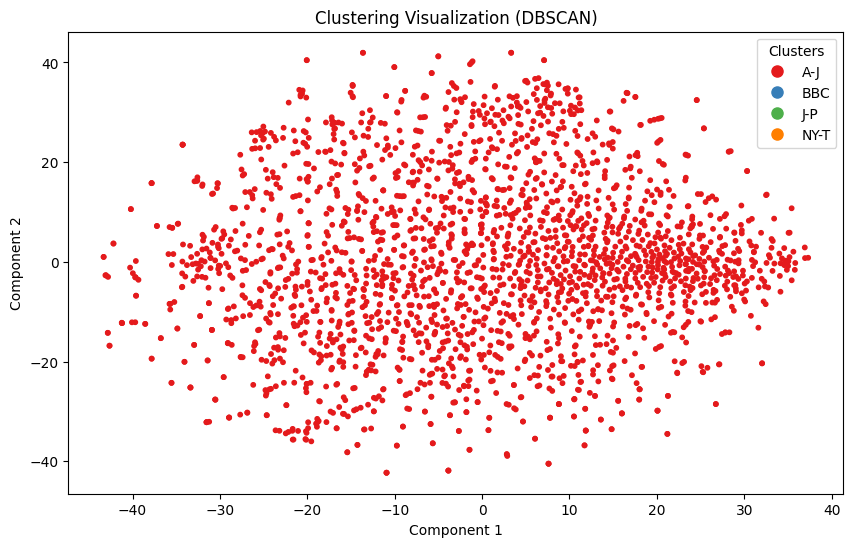

--------------------glove_clean_withIDF_withoutStopWords.csv--------------------
Precision: 0.06519249903156342
Recall: 0.2553282182438193
F1 Score: 0.10386526501055873
Accuracy: 0.2553282182438193


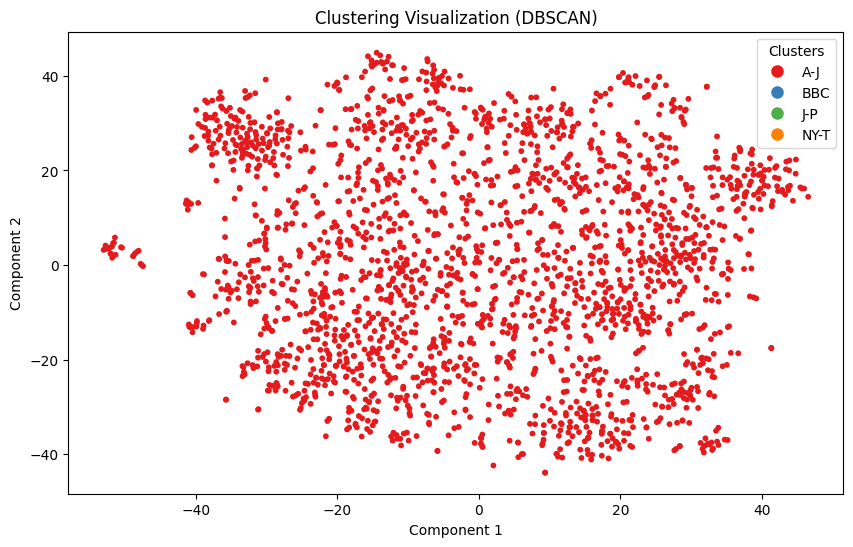

--------------------glove_clean_withIDF_withStopWords.csv--------------------
Precision: 0.06519249903156342
Recall: 0.2553282182438193
F1 Score: 0.10386526501055873
Accuracy: 0.2553282182438193


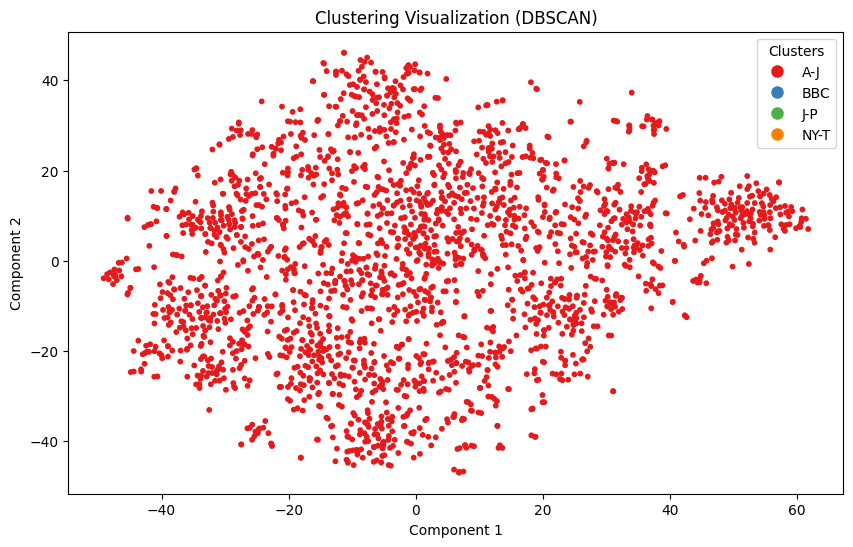

--------------------glove_clean_withoutIdf_withoutStopWords.csv--------------------
Precision: 0.06519249903156342
Recall: 0.2553282182438193
F1 Score: 0.10386526501055873
Accuracy: 0.2553282182438193


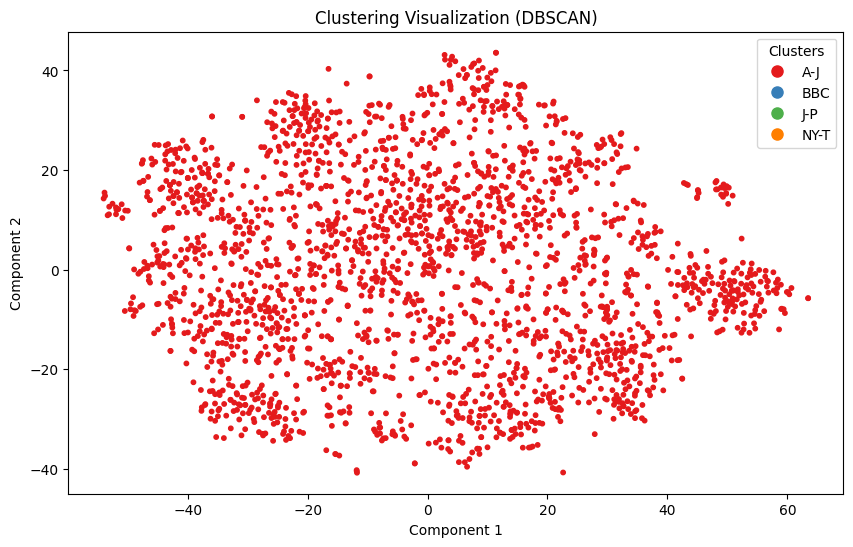

--------------------glove_clean_withoutIdf_withStopWords.csv--------------------
Precision: 0.06519249903156342
Recall: 0.2553282182438193
F1 Score: 0.10386526501055873
Accuracy: 0.2553282182438193


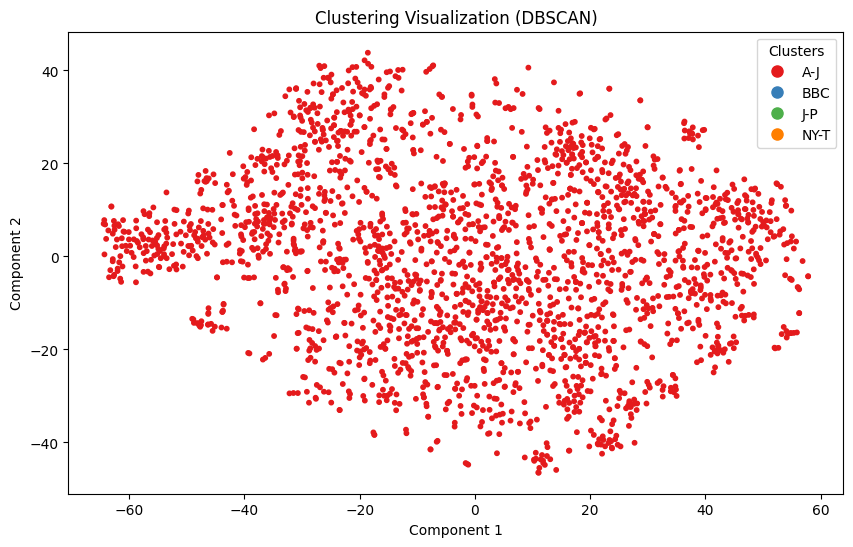

--------------------glove_lemma_withIDF_withoutStopWords.csv--------------------
Precision: 0.06519249903156342
Recall: 0.2553282182438193
F1 Score: 0.10386526501055873
Accuracy: 0.2553282182438193


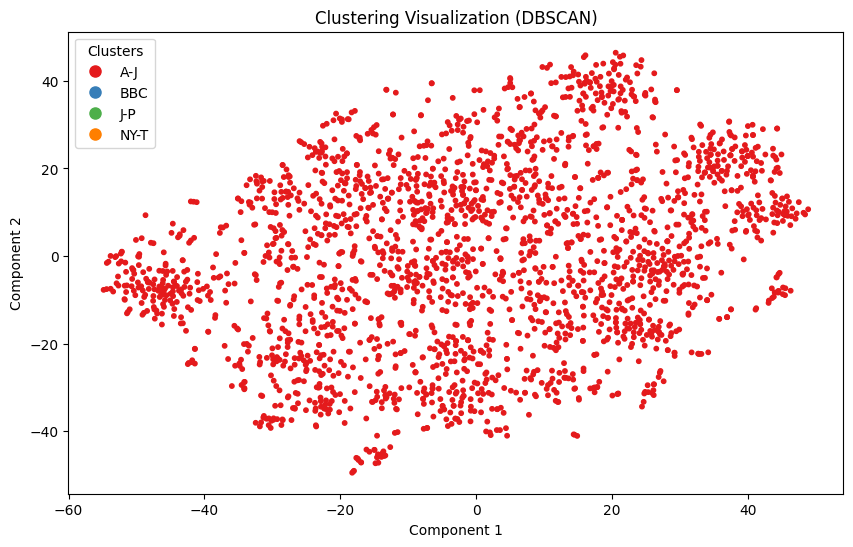

--------------------glove_lemma_withIDF_withStopWords.csv--------------------
Precision: 0.06519249903156342
Recall: 0.2553282182438193
F1 Score: 0.10386526501055873
Accuracy: 0.2553282182438193


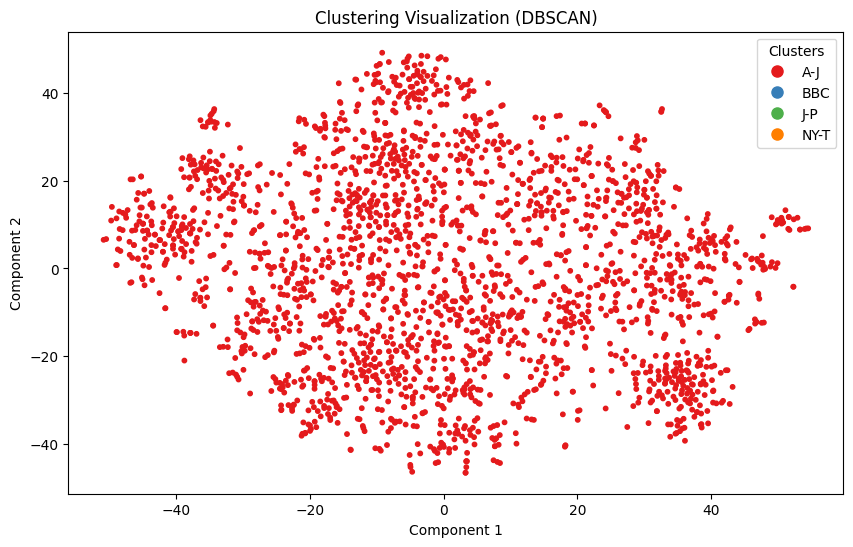

--------------------glove_lemma_withoutIdf_withoutStopWords.csv--------------------
Precision: 0.06519249903156342
Recall: 0.2553282182438193
F1 Score: 0.10386526501055873
Accuracy: 0.2553282182438193


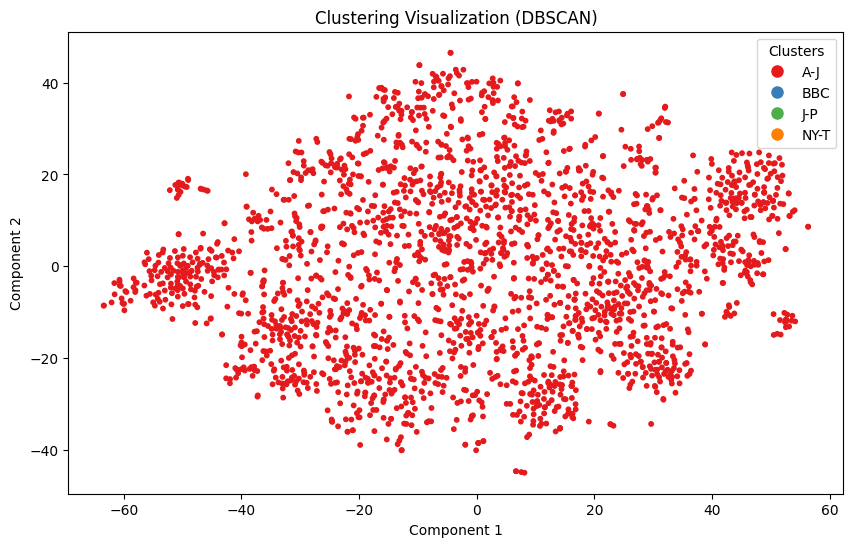

--------------------glove_lemma_withoutIdf_withStopWords.csv--------------------
Precision: 0.06519249903156342
Recall: 0.2553282182438193
F1 Score: 0.10386526501055873
Accuracy: 0.2553282182438193


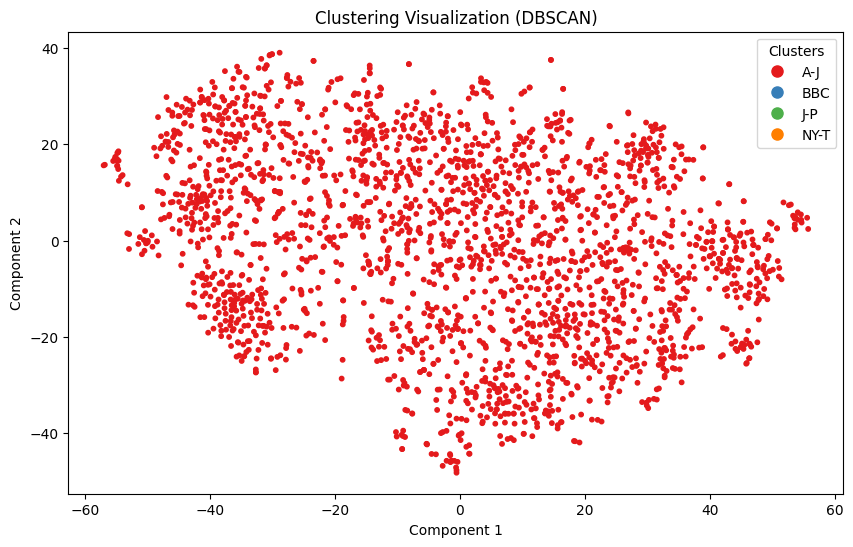

--------------------TF-IDF clean--------------------
Precision: 0.06519249903156342
Recall: 0.2553282182438193
F1 Score: 0.10386526501055873
Accuracy: 0.2553282182438193


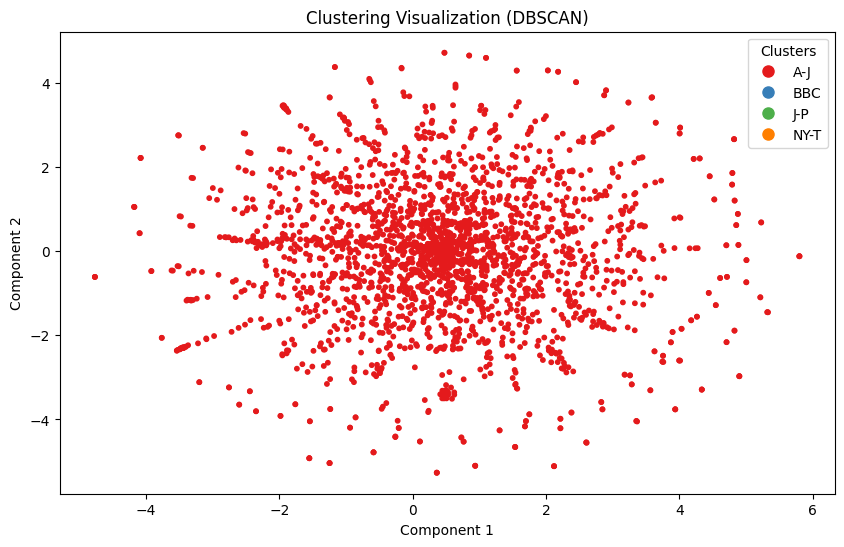

--------------------TF-IDF lemma--------------------
Precision: 0.06519249903156342
Recall: 0.2553282182438193
F1 Score: 0.10386526501055873
Accuracy: 0.2553282182438193


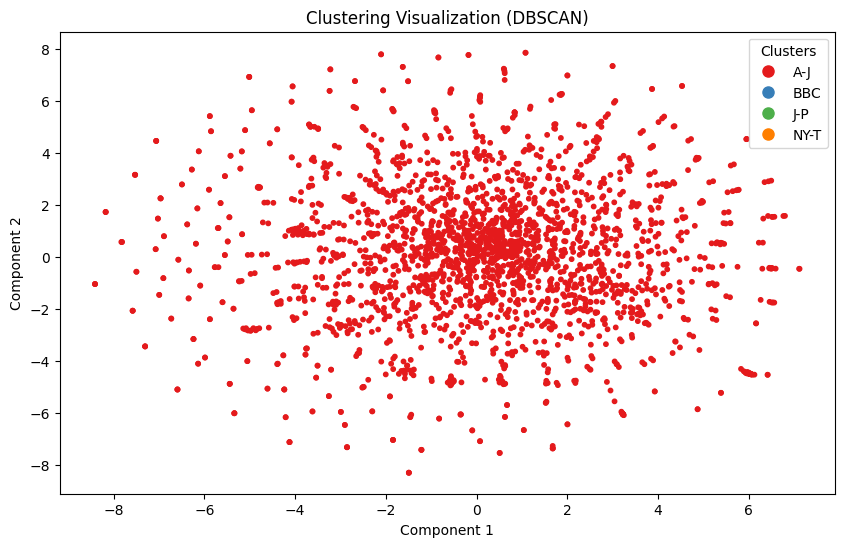

--------------------w2v_clean_withIDF_withoutStopWords.csv--------------------
Precision: 0.06519249903156342
Recall: 0.2553282182438193
F1 Score: 0.10386526501055873
Accuracy: 0.2553282182438193


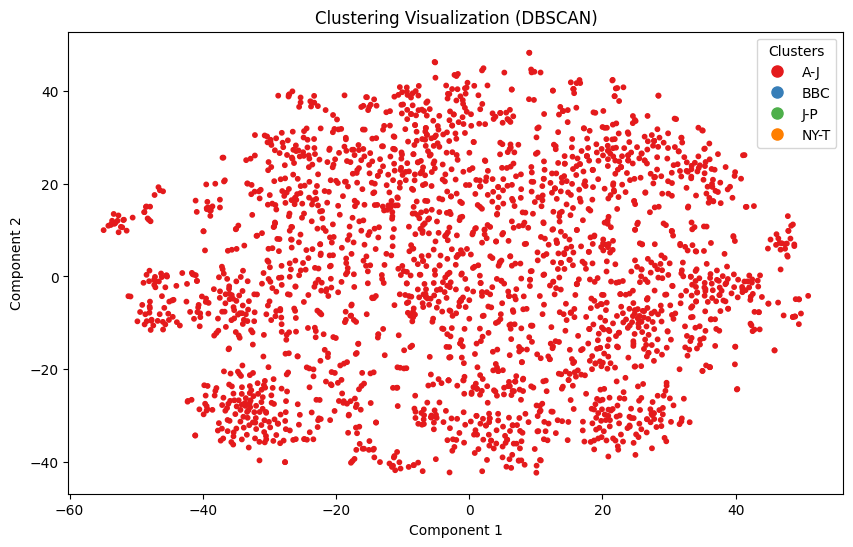

--------------------w2v_clean_withIDF_withStopWords.csv--------------------
Precision: 0.06519249903156342
Recall: 0.2553282182438193
F1 Score: 0.10386526501055873
Accuracy: 0.2553282182438193


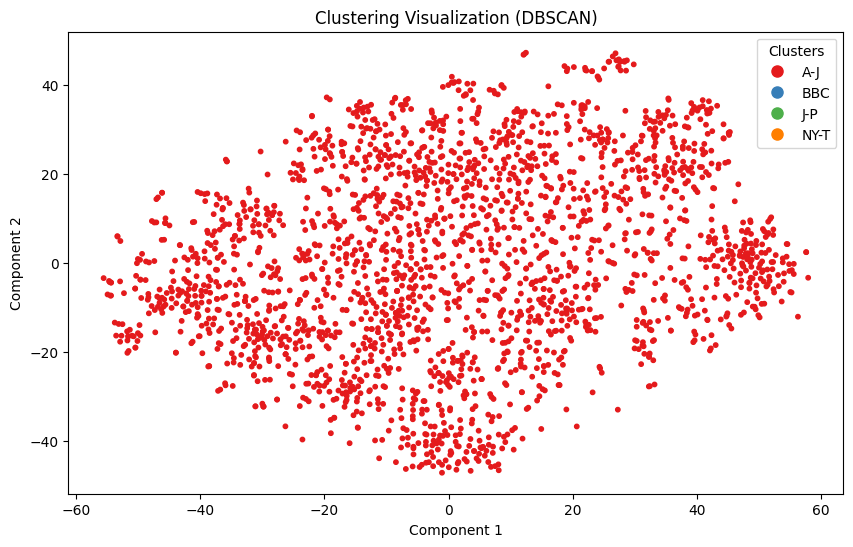

--------------------w2v_clean_withoutIdf_withoutStopWords.csv--------------------
Precision: 0.06519249903156342
Recall: 0.2553282182438193
F1 Score: 0.10386526501055873
Accuracy: 0.2553282182438193


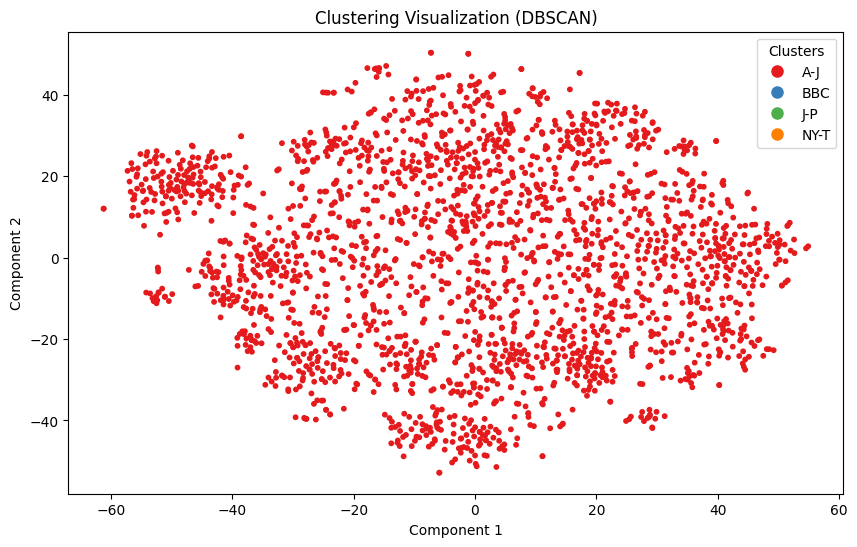

--------------------w2v_clean_withoutIdf_withStopWords.csv--------------------
Precision: 0.06519249903156342
Recall: 0.2553282182438193
F1 Score: 0.10386526501055873
Accuracy: 0.2553282182438193


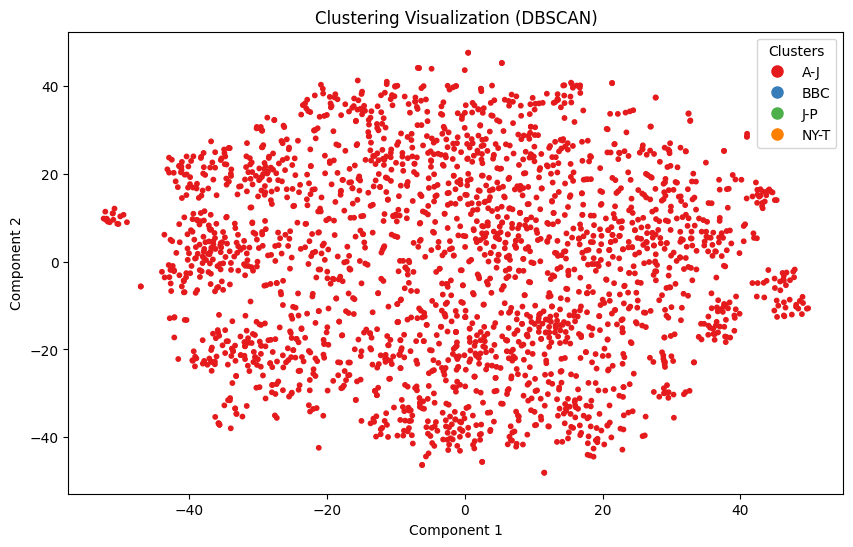

--------------------w2v_lemma_withIDF_withoutStopWords.csv--------------------
Precision: 0.06519249903156342
Recall: 0.2553282182438193
F1 Score: 0.10386526501055873
Accuracy: 0.2553282182438193


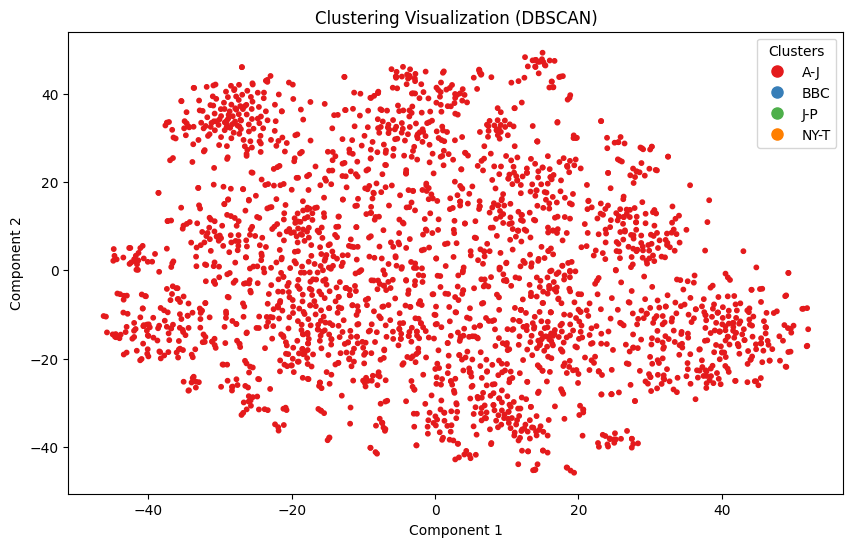

--------------------w2v_lemma_withIDF_withStopWords.csv--------------------
Precision: 0.06519249903156342
Recall: 0.2553282182438193
F1 Score: 0.10386526501055873
Accuracy: 0.2553282182438193


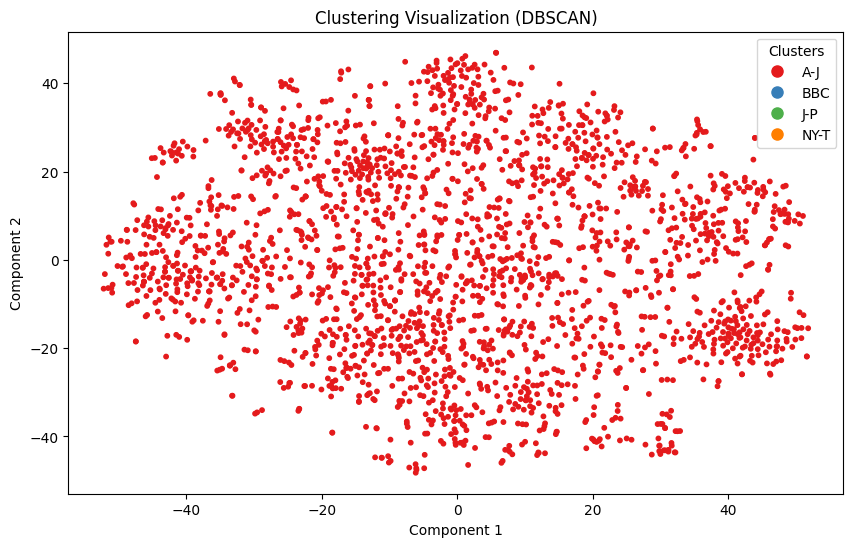

--------------------w2v_lemma_withoutIdf_withoutStopWords.csv--------------------
Precision: 0.06519249903156342
Recall: 0.2553282182438193
F1 Score: 0.10386526501055873
Accuracy: 0.2553282182438193


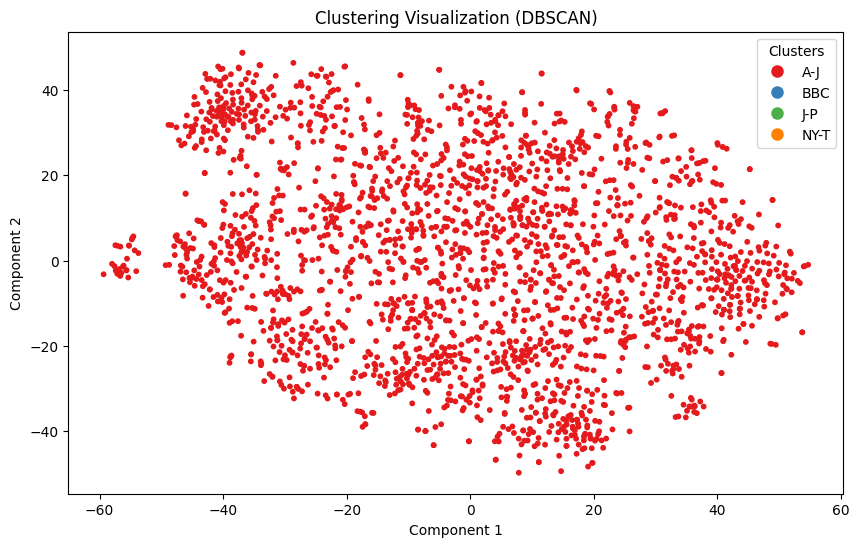

--------------------w2v_lemma_withoutIdf_withStopWords.csv--------------------
Precision: 0.06519249903156342
Recall: 0.2553282182438193
F1 Score: 0.10386526501055873
Accuracy: 0.2553282182438193


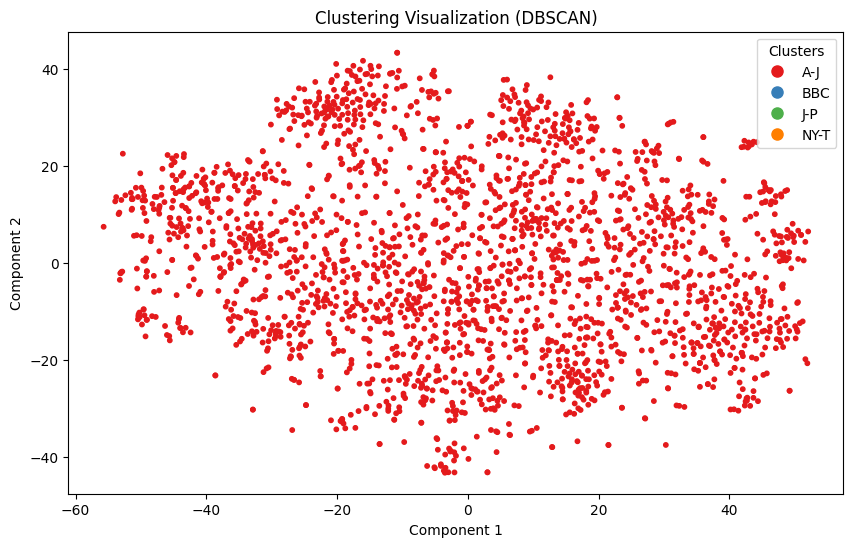

In [148]:
# for method in ['kmeans', 'dbscan', 'gmm']:
#     apply_to_all_matrices(cluster_and_evaluate, method)
apply_to_all_matrices(cluster_and_evaluate, 'dbscan')